## Question:
Is there a statistical difference in the odds of winning a game when a team is playing in front of their home crowd?

## Hypothesis 1:
**Null Hypothesis** H<sub>0</sub> = There is *no statistical difference* in the odds of winning a game when a team is playing in front of their home crowd 

**Alternative Hypothesis** H<sub>a</sub> = There is *always* a difference in the odds of winning a game when a team is playing in front of their home crowd.

In [1]:
import pandas as pd
import numpy as np
import psycopg2
from scipy import stats
import seaborn as sns

In [2]:
conn = psycopg2.connect('dbname=football_db')

In [3]:
cur = conn.cursor()

In [4]:
columns = ['id', 'home_goal', 'away_goal', 'result']

query = f"""
SELECT match_api_id, home_team_goal, away_team_goal, 
CASE WHEN home_team_goal > away_team_goal THEN 'Win' 
         ELSE 'NoWin' END as Result
FROM Match
"""

cur.execute(query)
data = cur.fetchall()

In [5]:
df = pd.DataFrame(data, columns=columns)

In [6]:
df.head()

,id,home_goal,away_goal,result
0,492473,1,1,NoWin
1,492474,0,0,NoWin
2,492475,0,3,NoWin
3,492476,5,0,Win
4,492477,1,3,NoWin


In [7]:
total_wins = len(df[df['result'] == 'Win'])
total_wins

11917

In [8]:
total_games = len(df['result'])
total_games

25979

In [9]:
# Population mean (μ): Win rate for all home game wins for entire dataset
mu = total_wins / total_games
mu

0.45871665576042187

In [10]:
sample_size = 2000
number_of_games = 2000
samples = np.zeros(sample_size)
for i in range(sample_size):
    """Taking a sample size of the win rate for home games"""
    games = df.iloc[np.random.randint(low=0, high=len(df), size=number_of_games), :]
    win_rate = len(games[games['result'] == 'Win']) / number_of_games
    samples[i] = win_rate


In [11]:
sample_mean = samples.mean()
sample_mean

0.45832500000000004

In [12]:
std = np.std(samples, ddof=1)
std

0.010988926392128838

In [13]:
# T-Test to compare the average mean to the population mean
t = (sample_mean - mu) / (std / np.sqrt(sample_size))
t

-1.593911675866488

In [14]:
# Degrees of Freedom
df = sample_size - 1

### Calculating Critical T-Value
If the test statistic is more extreme than the critical value, then the null hypothesis is rejected in favor of the alternative hypothesis. If the test statistic is not as extreme as the critical value, then the null hypothesis is not rejected.

In [15]:
t_crit = np.round(stats.t.ppf(1 - 0.05, df), 3)
t_crit

1.646

In [16]:
results = stats.ttest_1samp(a=samples, popmean=mu)
print(results)
print('\n')

if (results[0]>t_crit) and (results[1]<0.05):
    print ("Null hypothesis rejected. Results are statistically significant with t-value =", 
           round(results[0], 2), "and p-value =", np.round((results[1]), 4))
else:
    print ("Null hypothesis is Accepted")

Ttest_1sampResult(statistic=-1.593911675866488, pvalue=0.11111390677346769)


Null hypothesis is Accepted


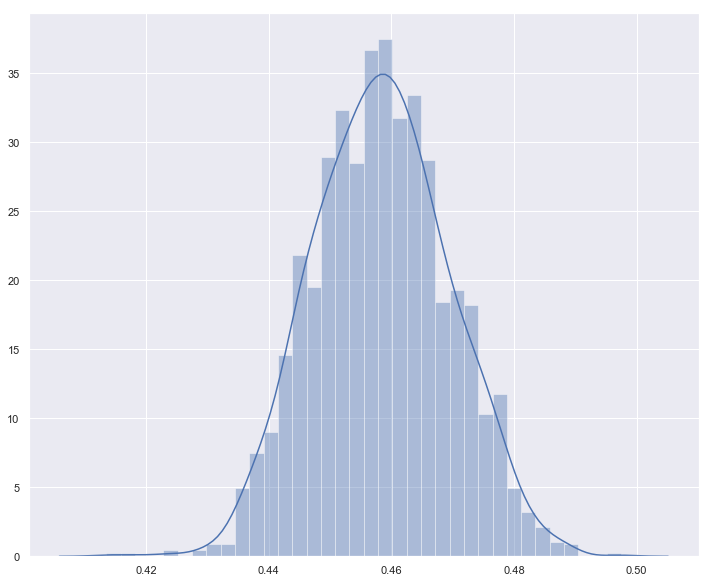

In [18]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(samples)

## Result:
While limiting alpha to 0.05, The P-value is > 0.05. This concludes that there is no statistical difference when a team wins in front of a home crowd or wins at away games, therefore accepting the null hypothesis.

In [ ]:
columns = ['team_short_name', 'team_api_id', 'Category', 'Result', 'Count' ]

query = f"""
SELECT A.team_short_name as Team, B.* FROM
(SELECT T.team_api_id, 'Home' as Category,
CASE WHEN M1.home_team_goal - M1.away_team_goal > 0 THEN 'Win' ELSE 'No' END as Result,
COUNT(*) as Count
FROM Team T
JOIN Match M1 ON T.team_api_id = M1.home_team_api_id
GROUP BY T.team_api_id, Result
UNION SELECT T.team_api_id, 'Away' as Category,
CASE WHEN M1.home_team_goal - M1.away_team_goal < 0 THEN 'Win' ELSE 'No' END as Result,
COUNT(*) as Count
FROM Team T
JOIN Match M1 ON T.team_api_id = M1.away_team_api_id
GROUP BY T.team_api_id, Result) as B
JOIN Team A ON B.team_api_id = A.team_api_id
"""

cur.execute(query)
data = cur.fetchall()

In [ ]:
df = pd.DataFrame(data, columns=columns)

In [ ]:
df.head(5)

In [ ]:
columns = ['team_short_name', 'team_api_id']

query = f"""
SELECT {', '.join(columns)}
FROM Team;
"""

In [ ]:
cur.execute(query)
data = cur.fetchall()

In [ ]:
team_df = pd.DataFrame(data, columns=columns)
team_df.head()

In [ ]:
np.random.seed(0)
samples = df.iloc[np.random.randint(low=0, high=len(df), size=100), :]

In [ ]:
mu = df[df['Result'] == "Win"].count() / df.count()
mu

In [ ]:
x_bar = samples[samples['Result'] == "Win"].count() / samples.count()
x_bar

In [ ]:
columns = ['Result', 'Count']

query = f"""
SELECT Home_Result, COUNT(*) as Count FROM
(SELECT B.team_short_name as Home,  C.team_short_name as Away,  
(CASE WHEN M.home_team_goal - M.away_team_goal > 0 THEN 'Win' 
      WHEN  M.home_team_goal - M.away_team_goal = 0 THEN 'Draw'
      ELSE 'Lose' END) as Home_Result 
FROM Match M
JOIN Team B ON M.home_team_api_id = B.team_api_id
JOIN Team C ON M.away_team_api_id = C.team_api_id) AS T
GROUP BY Home_Result
"""

cur.execute(query)